# Gerardo de Miguel González

# Binary Classification Proof of Concept

## Libraries

In [1]:
#::GMG::Which libraries are there?
list.files(R.home('library'))

[1] "base"         "boot"         "class"        "cluster"      "codetools"   
 [6] "compiler"     "datasets"     "foreign"      "graphics"     "grDevices"   
[11] "grid"         "KernSmooth"   "lattice"      "MASS"         "Matrix"      
[16] "methods"      "mgcv"         "nlme"         "nnet"         "parallel"    
[21] "rpart"        "spatial"      "splines"      "stats"        "stats4"      
[26] "survival"     "tcltk"        "tools"        "translations" "utils"

**::GMG::** Original `stdout`:

```shell
     'base' 'boot' 'class' 'cluster' 'codetools' 'compiler' 'datasets' 'foreign' 'graphics' 'grDevices' 'grid' 'KernSmooth' 'lattice' 'MASS' 'Matrix' 'methods' 'mgcv' 'nlme' 'nnet' 'parallel' 'rpart' 'spatial' 'splines' 'stats' 'stats4' 'survival' 'tcltk' 'tools' 'translations' 'utils' 
```

In [2]:
#::GMG::Helper function to install missing libraries before loading them
# https://stackoverflow.com/questions/4090169/elegant-way-to-check-for-missing-packages-and-install-them
using_w<-function(...) {
    libs<-unlist(list(...))
    req<-unlist(lapply(libs,require,character.only=TRUE))
    need<-libs[req==FALSE]
    n<-length(need)
    if(n>0){
        libsmsg<-if(n>2) paste(paste(need[1:(n-1)],collapse=", "),",",sep="") else need[1]
        print(libsmsg)
        if(n>1){
            libsmsg<-paste(libsmsg," and ", need[n],sep="")
        }
        libsmsg<-paste("The following packages could not be found: ",libsmsg,"\n\r\n\rInstall missing packages?",collapse="")
        if(winDialog(type = c("yesno"), libsmsg)=="YES"){       
            install.packages(need)
            lapply(need,require,character.only=TRUE)
        }
    }
}

In [3]:
#::GMG::Helper function to install missing libraries before loading them
# https://stackoverflow.com/questions/4090169/elegant-way-to-check-for-missing-packages-and-install-them
using<-function(...) {
    libs<-unlist(list(...))
    req<-unlist(lapply(libs,require,character.only=TRUE))
    need<-libs[req==FALSE]
    if(length(need)>0){ 
        install.packages(need)
        lapply(need,require,character.only=TRUE)
    }
}

In [4]:
#::GMG::I'm going to use ... 
# ... mlbench for getting pima indians dataset ...
# https://cran.r-project.org/web/packages/mlbench/index.html
# https://cran.r-project.org/web/packages/mlbench/mlbench.pdf
# ... caTools for train/test splitting datasets ...
# https://cran.r-project.org/web/packages/caTools/index.html
# https://cran.r-project.org/web/packages/caTools/caTools.pdf
# ... dataPreparation: Automated Data Preparation ...
# https://cran.r-project.org/web/packages/dataPreparation/index.html
# https://cran.r-project.org/web/packages/dataPreparation/vignettes/train_test_prep.html
# ... correlation plot (corrplot) for EDA visualization ...
# http://www.sthda.com/english/wiki/visualize-correlation-matrix-using-correlogram
# https://cran.r-project.org/web/packages/corrplot/index.html
# ... Machine Learning in R (most of things I'll need)
# https://cran.r-project.org/web/packages/mlr/index.html
# https://cran.r-project.org/web/packages/mlr/mlr.pdf
#::NOTE::What about tidyverse?
# https://cran.r-project.org/web/packages/tidyverse/index.html
# https://www.tidyverse.org/ 
using('mlbench', 'caTools', 'dataPreparation', 'corrplot', 'mlr')

Loading required package: mlbench
Loading required package: caTools
Loading required package: dataPreparation
Loading required package: lubridate

Attaching package: ‘lubridate’

The following object is masked from ‘package:base’:

    date

Loading required package: stringr
Loading required package: Matrix
Loading required package: progress
dataPreparation 0.4.0
Type dataPrepNews() to see new features/changes/bug fixes.
Loading required package: corrplot
corrplot 0.84 loaded
Loading required package: mlr
Loading required package: ParamHelpers


**::GMG::** stdout of installation (first time, a 5 min process!)

```shell
Loading required package: mlbench
Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘mlbench’”Loading required package: caTools
Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘caTools’”Loading required package: dataPreparation
Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘dataPreparation’”Loading required package: corrplot
Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘corrplot’”Loading required package: mlr
Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘mlr’”Installing packages into ‘/home/jovyan/R/x86_64-pc-linux-gnu-library/3.6’
(as ‘lib’ is unspecified)
also installing the dependencies ‘ellipsis’, ‘rlang’, ‘vctrs’, ‘hms’, ‘fastmatch’, ‘lubridate’, ‘progress’, ‘ParamHelpers’, ‘BBmisc’, ‘parallelMap’

Loading required package: mlbench
Loading required package: caTools
Loading required package: dataPreparation
Loading required package: lubridate

Attaching package: ‘lubridate’

The following object is masked from ‘package:base’:

    date

Loading required package: stringr
Loading required package: Matrix
Loading required package: progress
Error: package or namespace load failed for ‘progress’ in loadNamespace(i, c(lib.loc, .libPaths()), versionCheck = vI[[i]]):
 namespace ‘rlang’ 0.3.4 is already loaded, but >= 0.4.0 is required
Loading required package: corrplot
corrplot 0.84 loaded
Loading required package: mlr
Loading required package: ParamHelpers
Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
```

and yields TRUE, TRUE, **FALSE**, TRUE, TRUE which suggests some *trouble* with `dataPreparation` ([\*]()) ... Besides there's been an **error** on yhe `progress` ([\*](https://cran.r-project.org/web/packages/progress/index.html)) package. In fact, `dataPreparation` depends on that package, among others: R (≥ 3.3.0), lubridate, stringr, Matrix, **progress**.

**::GMG::** There's a problem with [`rlang`](https://cran.r-project.org/web/packages/rlang/index.html) because if I try to [see the installed packages]() I get an error:

```R
> old.packages()

> ERROR while rich displaying an object: Error in loadNamespace(i, c(lib.loc, .libPaths()), versionCheck = vI[[i]]): namespace ‘rlang’ 0.3.4 is already loaded, but >= 0.4.0 is required

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)

[...]
```

In order to fix that I decided to [update the installed packages](https://www.neonscience.org/packages-in-r) which takes *15 minutes*.

```R
# update all available packages
> update.packages(ask = FALSE)

> also installing the dependencies ‘brew’, ‘commonmark’, ‘xml2’, ‘praise’, ‘roxygen2’, ‘testthat’
Error in install.packages(update[instlib == l, "Package"], l, contriburl = contriburl, : unable to install packages
Traceback:

1. update.packages(ask = FALSE)
2. install.packages(update[instlib == l, "Package"], l, contriburl = contriburl, 
 .     method = method, available = available, ..., type = type)
3. stop("unable to install packages")
```

**Another error**. So I'm lost here.

**GMG::** I fix the issue on command line updating the packages

```R
> old.packages()
         Package    LibPath              Installed  Built   ReposVer
boot     "boot"     "/usr/lib/R/library" "1.3-20"   "3.5.0" "1.3-23"
cluster  "cluster"  "/usr/lib/R/library" "2.0.8"    "3.5.3" "2.1.0"
foreign  "foreign"  "/usr/lib/R/library" "0.8-70"   "3.5.0" "0.8-71"
MASS     "MASS"     "/usr/lib/R/library" "7.3-51.1" "3.5.1" "7.3-51.4"
survival "survival" "/usr/lib/R/library" "2.43-3"   "3.5.1" "2.44-1.1"
         Repository
boot     "https://cloud.r-project.org/src/contrib"
cluster  "https://cloud.r-project.org/src/contrib"
foreign  "https://cloud.r-project.org/src/contrib"
MASS     "https://cloud.r-project.org/src/contrib"
survival "https://cloud.r-project.org/src/contrib"

> update.packages()
boot :
 Version 1.3-20 installed in /usr/lib/R/library
 Version 1.3-23 available at https://cloud.r-project.org
Update? (Yes/no/cancel)

[...]

survival :
 Version 2.43-3 installed in /usr/lib/R/library
 Version 2.44-1.1 available at https://cloud.r-project.org
Update? (Yes/no/cancel) yes
Warning in install.packages(update[instlib == l, "Package"], l, contriburl = contriburl,  :
  'lib = "/usr/lib/R/library"' is not writable

Would you like to use a personal library instead? (yes/No/cancel) yes

[...]

** R
** data
*** moving datasets to lazyload DB
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
*** copying figures
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (survival)

The downloaded source packages are in
        ‘/tmp/RtmpH5XaDg/downloaded_packages’
```

and installing `dataPreparation`:

```R
`> install.packages('dataPreparation')
Installing package into ‘/home/jovyan/R/x86_64-pc-linux-gnu-library/3.6’
(as ‘lib’ is unspecified)
trying URL 'https://cloud.r-project.org/src/contrib/dataPreparation_0.4.0.tar.gz'
Content type 'application/x-gzip' length 1286671 bytes (1.2 MB)
==================================================
downloaded 1.2 MB

* installing *source* package ‘dataPreparation’ ...
** package ‘dataPreparation’ successfully unpacked and MD5 sums checked
** using staged installation
** R
** data
*** moving datasets to lazyload DB
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (dataPreparation)

The downloaded source packages are in
        ‘/tmp/RtmpH5XaDg/downloaded_packages’

``` 



## Dataset

### load

In [5]:
#::GMG::Where am I?
# http://rfunction.com/archives/1042
getwd()

[1] "/home/jovyan/work/tfm/pub"

In [6]:
#::GMG::What's it there?
list.files()

[1] "data"                                           
 [2] "LICENSE"                                        
 [3] "model"                                          
 [4] "poc-class-pima-indians-diabetes.ipynb"          
 [5] "poc-class-r-pima-indians-diabetes.ipynb"        
 [6] "poc-class-stratify-pima-indians-diabetes.ipynb" 
 [7] "poc-fs-embed-pima-indians-diabetes.ipynb"       
 [8] "poc-fs-filter-pima-indians-diabetes.ipynb"      
 [9] "poc-fs-wrapper-pima-indians-diabetes.ipynb"     
[10] "poc-model-selection-pima-indians-diabetes.ipynb"
[11] "README.md"

In [7]:
#::GMG::I've already downloaded from kaggle using my account the csv dataset
#       that is located in the data folder
# https://stat.ethz.ch/R-manual/R-devel/library/base/html/list.files.html
dir("data", pattern = "*.csv", full.names = TRUE, ignore.case = TRUE)

[1] "data/pima-indians-diabetes.csv"

In [8]:
#::GMG::Load the data into a data frame
pima <- read.csv('data/pima-indians-diabetes.csv')

In [9]:
head(pima)

Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<int>
6,148,72,35,0,33.6,0.627,50,1
1,85,66,29,0,26.6,0.351,31,0
8,183,64,0,0,23.3,0.672,32,1
1,89,66,23,94,28.1,0.167,21,0
0,137,40,35,168,43.1,2.288,33,1
5,116,74,0,0,25.6,0.201,30,0


In [10]:
#::GMG::I try to get to know the R object
# https://swcarpentry.github.io/r-novice-inflammation/13-supp-data-structures/
#    class() - what kind of object is it (high-level)?
#    typeof() - what is the object’s data type (low-level)?
#    length() - how long is it? What about two dimensional objects?
#    attributes() - does it have any metadata?
# http://www.studytrails.com/r/core/r_print_format/
# http://www.studytrails.com/r/core/r_console_printing/
# https://www.rdocumentation.org/packages/R.utils/versions/2.8.0/topics/printf
# 
cat('pima class and type: ', class(pima), typeof(pima))

pima class and type:  data.frame list

In [11]:
#attributes(pima)

**::GMG::** Attributes:

```R
$names
   'Pregnancies' 'Glucose' 'BloodPressure' 'SkinThickness' 'Insulin' 'BMI' 'DiabetesPedigreeFunction' 'Age' 'Outcome' 

$class
   'data.frame'

$row.names
   1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41  ... 765 766 767 768
```

In [12]:
cat('pima shape (rows, cols): ', nrow(pima), ncol(pima))

pima shape (rows, cols):  768 9

In [13]:
cat('pima features: \n', 
    format(attributes(pima)$names, justify = "none"), 
    fill = 10
   )

pima features: 
 
Pregnancies 
Glucose 
BloodPressure 
SkinThickness 
Insulin 
BMI 
DiabetesPedigreeFunction 
Age 
Outcome


In [14]:
#::GMG::With mlbench there's an aalternative to get the pima indians diabetes dataset
# https://cran.r-project.org/web/packages/mlbench/mlbench.pdf
data(PimaIndiansDiabetes)

In [15]:
head(PimaIndiansDiabetes)

pregnant,glucose,pressure,triceps,insulin,mass,pedigree,age,diabetes
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
6,148,72,35,0,33.6,0.627,50,pos
1,85,66,29,0,26.6,0.351,31,neg
8,183,64,0,0,23.3,0.672,32,pos
1,89,66,23,94,28.1,0.167,21,neg
0,137,40,35,168,43.1,2.288,33,pos
5,116,74,0,0,25.6,0.201,30,neg


In [16]:
#::GMG::There are two versions in mlbench (!)
#::NOTE::What is the difference?
data(PimaIndiansDiabetes2)

In [17]:
head(PimaIndiansDiabetes2)

pregnant,glucose,pressure,triceps,insulin,mass,pedigree,age,diabetes
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
6,148,72,35,NA,33.6,0.627,50,pos
1,85,66,29,NA,26.6,0.351,31,neg
8,183,64,NA,NA,23.3,0.672,32,pos
1,89,66,23,94,28.1,0.167,21,neg
0,137,40,35,168,43.1,2.288,33,pos
5,116,74,NA,NA,25.6,0.201,30,neg


### exploratory data analysis

In [18]:
#::GMG::Here I can see the variables (datasets and functions in memory)
ls()

[1] "pima"                 "PimaIndiansDiabetes"  "PimaIndiansDiabetes2"
[4] "using"                "using_w"

**::GMG::** This dataset consists of 768 observations of 9 variables: 8 variables which will be used as model predictors (number of times pregnant, plasma glucose concentration, diastolic blood pressure (mm Hg), triceps skin fold thickness (in mm), 2-hr serum insulin measure, body mass index, a diabetes pedigree function, and age) and 1 outcome variable (whether or not the patient has diabetes)

In [19]:
#::GMG::There are subtle differences between the kaggle and mlbench datasets
#       i.e. PimaIndiansDiabetes (say, v1) has the class as a factor (R compliant)
str(PimaIndiansDiabetes)

'data.frame':	768 obs. of  9 variables:
 $ pregnant: num  6 1 8 1 0 5 3 10 2 8 ...
 $ glucose : num  148 85 183 89 137 116 78 115 197 125 ...
 $ pressure: num  72 66 64 66 40 74 50 0 70 96 ...
 $ triceps : num  35 29 0 23 35 0 32 0 45 0 ...
 $ insulin : num  0 0 0 94 168 0 88 0 543 0 ...
 $ mass    : num  33.6 26.6 23.3 28.1 43.1 25.6 31 35.3 30.5 0 ...
 $ pedigree: num  0.627 0.351 0.672 0.167 2.288 ...
 $ age     : num  50 31 32 21 33 30 26 29 53 54 ...
 $ diabetes: Factor w/ 2 levels "neg","pos": 2 1 2 1 2 1 2 1 2 2 ...


In [20]:
summary(PimaIndiansDiabetes)

    pregnant         glucose         pressure         triceps     
 Min.   : 0.000   Min.   :  0.0   Min.   :  0.00   Min.   : 0.00  
 1st Qu.: 1.000   1st Qu.: 99.0   1st Qu.: 62.00   1st Qu.: 0.00  
 Median : 3.000   Median :117.0   Median : 72.00   Median :23.00  
 Mean   : 3.845   Mean   :120.9   Mean   : 69.11   Mean   :20.54  
 3rd Qu.: 6.000   3rd Qu.:140.2   3rd Qu.: 80.00   3rd Qu.:32.00  
 Max.   :17.000   Max.   :199.0   Max.   :122.00   Max.   :99.00  
    insulin           mass          pedigree           age        diabetes 
 Min.   :  0.0   Min.   : 0.00   Min.   :0.0780   Min.   :21.00   neg:500  
 1st Qu.:  0.0   1st Qu.:27.30   1st Qu.:0.2437   1st Qu.:24.00   pos:268  
 Median : 30.5   Median :32.00   Median :0.3725   Median :29.00            
 Mean   : 79.8   Mean   :31.99   Mean   :0.4719   Mean   :33.24            
 3rd Qu.:127.2   3rd Qu.:36.60   3rd Qu.:0.6262   3rd Qu.:41.00            
 Max.   :846.0   Max.   :67.10   Max.   :2.4200   Max.   :81.00            

**::GMG::** It's explained in the [mlbench documentation](https://cran.r-project.org/web/packages/mlbench/mlbench.pdf) (pp. 29):

> The data set `PimaIndiansDiabetes2` contains a corrected version of the original data set.  While the UCI repository index claims that there are no missing values, closer inspection of the data shows **several physical impossibilities**, e.g., blood pressure or body mass index of 0. In `PimaIndiansDiabetes2`, all *zero values* of glucose, pressure, triceps, insulin and mass have been **set to NA**.

In [21]:
#::GMG::PimaIndiansDiabetes2 (say, v2) has the outliers from 
#       glucose, pressure, triceps, insulin and mass as NAs
str(PimaIndiansDiabetes2)

'data.frame':	768 obs. of  9 variables:
 $ pregnant: num  6 1 8 1 0 5 3 10 2 8 ...
 $ glucose : num  148 85 183 89 137 116 78 115 197 125 ...
 $ pressure: num  72 66 64 66 40 74 50 NA 70 96 ...
 $ triceps : num  35 29 NA 23 35 NA 32 NA 45 NA ...
 $ insulin : num  NA NA NA 94 168 NA 88 NA 543 NA ...
 $ mass    : num  33.6 26.6 23.3 28.1 43.1 25.6 31 35.3 30.5 NA ...
 $ pedigree: num  0.627 0.351 0.672 0.167 2.288 ...
 $ age     : num  50 31 32 21 33 30 26 29 53 54 ...
 $ diabetes: Factor w/ 2 levels "neg","pos": 2 1 2 1 2 1 2 1 2 2 ...


In [22]:
#::GMG::NA counts yield the outliers (!)
summary(PimaIndiansDiabetes2)

    pregnant         glucose         pressure         triceps     
 Min.   : 0.000   Min.   : 44.0   Min.   : 24.00   Min.   : 7.00  
 1st Qu.: 1.000   1st Qu.: 99.0   1st Qu.: 64.00   1st Qu.:22.00  
 Median : 3.000   Median :117.0   Median : 72.00   Median :29.00  
 Mean   : 3.845   Mean   :121.7   Mean   : 72.41   Mean   :29.15  
 3rd Qu.: 6.000   3rd Qu.:141.0   3rd Qu.: 80.00   3rd Qu.:36.00  
 Max.   :17.000   Max.   :199.0   Max.   :122.00   Max.   :99.00  
                  NA's   :5       NA's   :35       NA's   :227    
    insulin            mass          pedigree           age        diabetes 
 Min.   : 14.00   Min.   :18.20   Min.   :0.0780   Min.   :21.00   neg:500  
 1st Qu.: 76.25   1st Qu.:27.50   1st Qu.:0.2437   1st Qu.:24.00   pos:268  
 Median :125.00   Median :32.30   Median :0.3725   Median :29.00            
 Mean   :155.55   Mean   :32.46   Mean   :0.4719   Mean   :33.24            
 3rd Qu.:190.00   3rd Qu.:36.60   3rd Qu.:0.6262   3rd Qu.:41.00            
 M

In [23]:
#::GMG::The kaggle version has different names for the features and class
#       Outcome is not a factor but a 'binary' integer type
#       Outliers (zeros in Glucose, BloodPressure, SkinThickness, Insulin and BMI) are kept
#       but not marked as NA
str(pima)

'data.frame':	768 obs. of  9 variables:
 $ Pregnancies             : int  6 1 8 1 0 5 3 10 2 8 ...
 $ Glucose                 : int  148 85 183 89 137 116 78 115 197 125 ...
 $ BloodPressure           : int  72 66 64 66 40 74 50 0 70 96 ...
 $ SkinThickness           : int  35 29 0 23 35 0 32 0 45 0 ...
 $ Insulin                 : int  0 0 0 94 168 0 88 0 543 0 ...
 $ BMI                     : num  33.6 26.6 23.3 28.1 43.1 25.6 31 35.3 30.5 0 ...
 $ DiabetesPedigreeFunction: num  0.627 0.351 0.672 0.167 2.288 ...
 $ Age                     : int  50 31 32 21 33 30 26 29 53 54 ...
 $ Outcome                 : int  1 0 1 0 1 0 1 0 1 1 ...


In [24]:
summary(pima)

  Pregnancies        Glucose      BloodPressure    SkinThickness  
 Min.   : 0.000   Min.   :  0.0   Min.   :  0.00   Min.   : 0.00  
 1st Qu.: 1.000   1st Qu.: 99.0   1st Qu.: 62.00   1st Qu.: 0.00  
 Median : 3.000   Median :117.0   Median : 72.00   Median :23.00  
 Mean   : 3.845   Mean   :120.9   Mean   : 69.11   Mean   :20.54  
 3rd Qu.: 6.000   3rd Qu.:140.2   3rd Qu.: 80.00   3rd Qu.:32.00  
 Max.   :17.000   Max.   :199.0   Max.   :122.00   Max.   :99.00  
    Insulin           BMI        DiabetesPedigreeFunction      Age       
 Min.   :  0.0   Min.   : 0.00   Min.   :0.0780           Min.   :21.00  
 1st Qu.:  0.0   1st Qu.:27.30   1st Qu.:0.2437           1st Qu.:24.00  
 Median : 30.5   Median :32.00   Median :0.3725           Median :29.00  
 Mean   : 79.8   Mean   :31.99   Mean   :0.4719           Mean   :33.24  
 3rd Qu.:127.2   3rd Qu.:36.60   3rd Qu.:0.6262           3rd Qu.:41.00  
 Max.   :846.0   Max.   :67.10   Max.   :2.4200           Max.   :81.00  
    Outcome  

In [25]:
#::GMG::Counting 'Outliers' a.k.a "physical impossibilities" (Zeros)
# https://stackoverflow.com/questions/22286957/count-the-number-of-non-zero-elements-of-each-column
apply(X = pima[c("Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI")], 
      MARGIN = 2, 
      FUN = function(c) sum(c == 0))

Glucose BloodPressure SkinThickness       Insulin           BMI 
            5            35           227           374            11

In [26]:
#::GMG::What do I do with the outliers?
#       Glucose, Insulin, BloodPressure, SkinThickness, and BMI 
#       Options: remove, impute, leave them untouched (lto)
#       Chosen: remove (Glucose, BloodPressure, BMI) + lto (SkinThickness, Insulin)
# https://stackoverflow.com/questions/9977686/how-to-remove-rows-with-a-zero-value-in-r
#::NOTE::I cannot remove the outliers from SkinThickness and Insuline 
#        because they're a big slice of the dataset (!)
row_sub <- apply(
             X = pima[c("Glucose", "BloodPressure", "BMI")], 
             MARGIN = 1, 
             FUN = function(row) all(row != 0)
)

***::NOTE::** I've [searched](https://www.google.com/search?client=firefox-b-d&q=a+person+can+have+zero+insulin%3F) about this *zero insulin issue*. So [it turns out](https://www.yourhormones.info/hormones/insulin/) that:

> People with type 1 diabetes produce very little or no insulin at all. This condition is caused when the beta cells that make insulin have been destroyed by antibodies (these are usually substances released by the body to fight against infections), hence they are unable to produce insulin.

So it remains only the `SkinThickness` zero physical impossibility *unresolved* and left it be.

In [27]:
#::GMG::I remove some of the outliers
pima_mod <- pima[row_sub,]

In [28]:
#::GMG::The somewhat cleaned dataset ...
str(pima_mod)

'data.frame':	724 obs. of  9 variables:
 $ Pregnancies             : int  6 1 8 1 0 5 3 2 4 10 ...
 $ Glucose                 : int  148 85 183 89 137 116 78 197 110 168 ...
 $ BloodPressure           : int  72 66 64 66 40 74 50 70 92 74 ...
 $ SkinThickness           : int  35 29 0 23 35 0 32 45 0 0 ...
 $ Insulin                 : int  0 0 0 94 168 0 88 543 0 0 ...
 $ BMI                     : num  33.6 26.6 23.3 28.1 43.1 25.6 31 30.5 37.6 38 ...
 $ DiabetesPedigreeFunction: num  0.627 0.351 0.672 0.167 2.288 ...
 $ Age                     : int  50 31 32 21 33 30 26 53 30 34 ...
 $ Outcome                 : int  1 0 1 0 1 0 1 1 0 1 ...


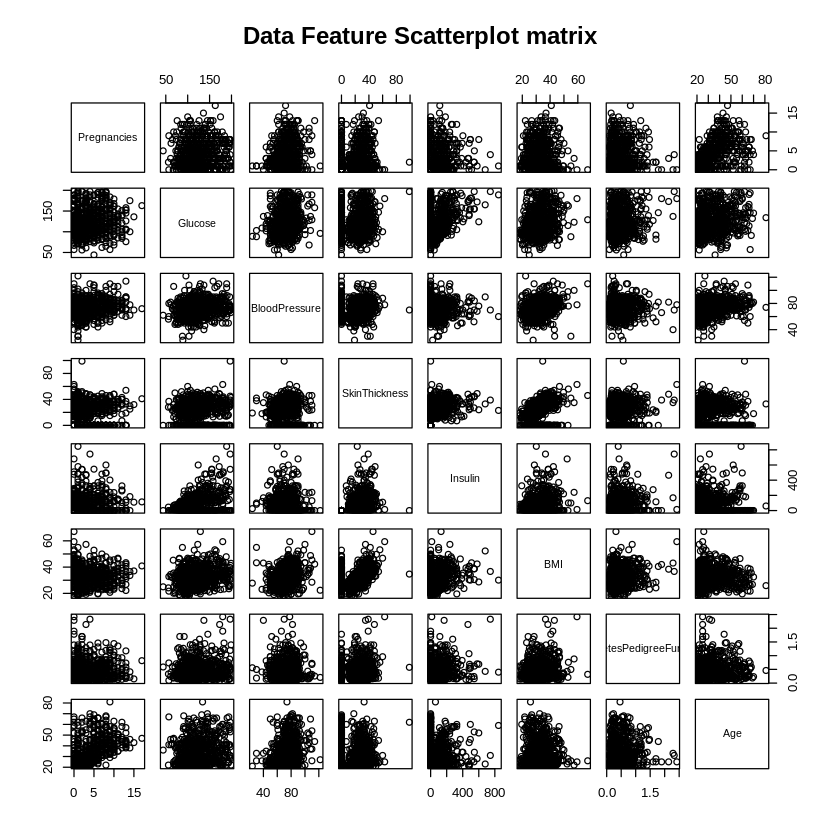

In [29]:
#::GMG::pair plot to see correlations between pairs of features
#::NOTE::See also:
# https://www.statmethods.net/advgraphs/trellis.html
# https://www.statmethods.net/graphs/scatterplot.html
# https://www.statmethods.net/advgraphs/layout.html
# https://www.r-bloggers.com/scatterplot-matrices-pair-plots-with-cdata-and-ggplot2/
pairs(pima_mod[1:8], pch = 21, main = 'Data Feature Scatterplot matrix')

In [30]:
#::GMG::Another way to see correlations with corrplot
# http://www.sthda.com/english/wiki/visualize-correlation-matrix-using-correlogram
# https://stat.ethz.ch/R-manual/R-devel/library/stats/html/cor.html
# https://www.statmethods.net/stats/correlations.html
#::NOTE::Se also https://www.statmethods.net/advgraphs/correlograms.html
M <- cor(pima_mod)

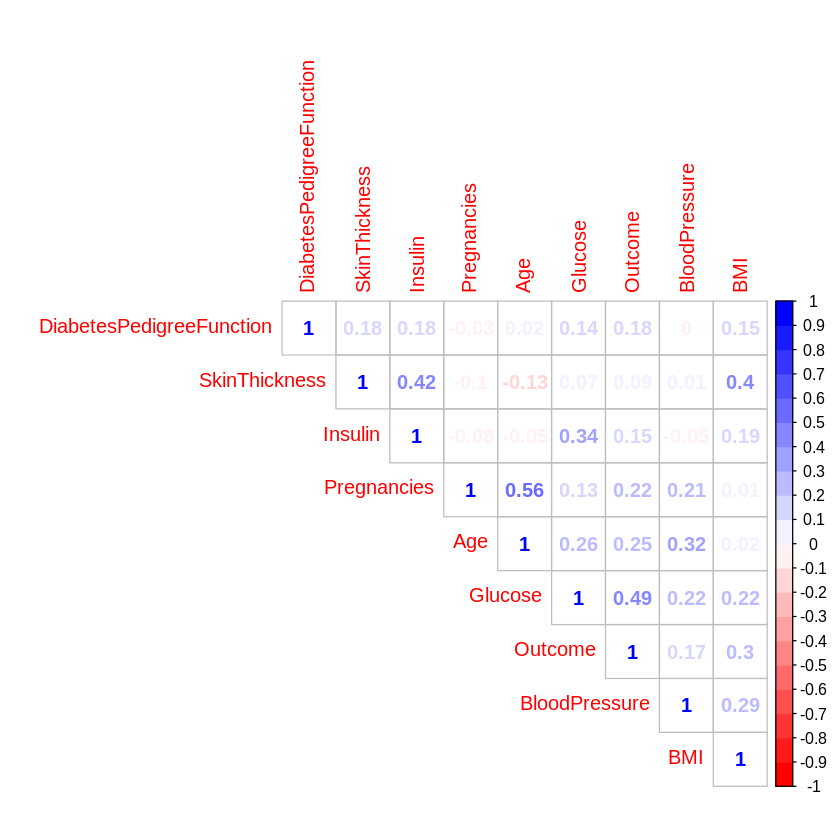

In [31]:
#::GMG::Plpot correlation plot
# http://www.sthda.com/english/wiki/visualize-correlation-matrix-using-correlogram
col<- colorRampPalette(c("red", "white", "blue"))(20)
corrplot(M, method="number", type="upper", order="hclust", col = col)

In [32]:
#::GMG::Variables created so far :)
ls()

[1] "col"                  "M"                    "pima"                
[4] "pima_mod"             "PimaIndiansDiabetes"  "PimaIndiansDiabetes2"
[7] "row_sub"              "using"                "using_w"

In [33]:
#::GMG::I change the Outcome variable into a 2 factor
# https://swcarpentry.github.io/r-novice-inflammation/12-supp-factors/
# https://www.stat.berkeley.edu/~s133/factors.html
# https://stackoverflow.com/questions/13613913/how-do-i-convert-certain-columns-of-a-data-frame-to-become-factors
pima_mod$Outcome <- as.factor(x = pima_mod$Outcome)
levels(pima_mod$Outcome) <- c('healthy', 'diabetes')

In [34]:
str(pima_mod)

'data.frame':	724 obs. of  9 variables:
 $ Pregnancies             : int  6 1 8 1 0 5 3 2 4 10 ...
 $ Glucose                 : int  148 85 183 89 137 116 78 197 110 168 ...
 $ BloodPressure           : int  72 66 64 66 40 74 50 70 92 74 ...
 $ SkinThickness           : int  35 29 0 23 35 0 32 45 0 0 ...
 $ Insulin                 : int  0 0 0 94 168 0 88 543 0 0 ...
 $ BMI                     : num  33.6 26.6 23.3 28.1 43.1 25.6 31 30.5 37.6 38 ...
 $ DiabetesPedigreeFunction: num  0.627 0.351 0.672 0.167 2.288 ...
 $ Age                     : int  50 31 32 21 33 30 26 53 30 34 ...
 $ Outcome                 : Factor w/ 2 levels "healthy","diabetes": 2 1 2 1 2 1 2 2 1 2 ...


In [35]:
#::GMG::Now I test the imbalance of the dataset
# http://metadatascience.com/2013/07/03/plotting-the-frequency-distribution-using-r/
table(pima_mod$Outcome)


 healthy diabetes 
     475      249 

In [36]:
prop.table(table(pima_mod$Outcome))


  healthy  diabetes 
0.6560773 0.3439227 

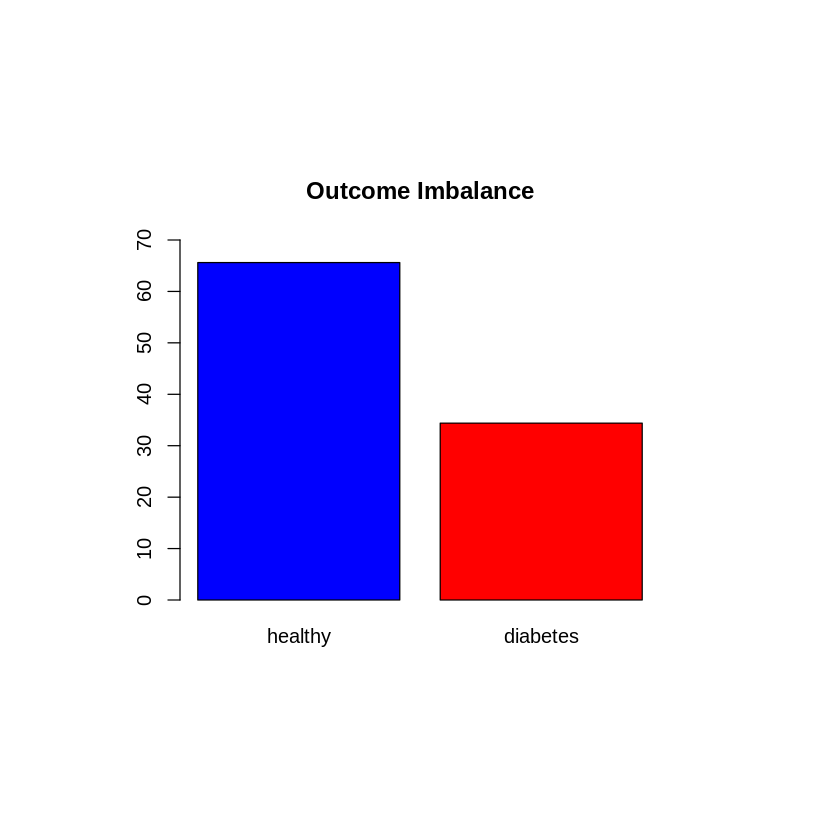

In [38]:
#::GMG::Plot the imbalance
# https://www.statmethods.net/advgraphs/parameters.html
# http://www.programmingr.com/content/positioning-charts-fig-and-fin/
#::NOTE::I don't know how to make the fig smaller and the margins tight (!?)
par(pin = c(4,3))
barplot(100*prop.table(table(pima_mod$Outcome)), 
        col = c('blue', 'red'),
        ylim = c(0,70),
        main = 'Outcome Imbalance')

## Train/Test Split

In [39]:
#::GMG::Let's make it reproducible
set.seed(1)

In [40]:
#::GMG::I do the customary train/test split BUT stratifiying (?) because of the imbalance
#       to make sure the percentages of healthy/diabetes hold in the train and test sets
#::NOTE::caTools has sample.split( Y, SplitRatio = 2/3, group = NULL )
# https://www.rdocumentation.org/packages/caTools/versions/1.17.1/topics/sample.split
# https://cran.r-project.org/web/packages/caTools/caTools.pdf
# Split data from vector Y into two sets in predefined ratio while preserving relative ratios of 
# differentlabels in Y. Used to split the data used during classification into train and test subsets.
#::NOTE::So it seems this does whay I want it to do ...
msk <- sample.split(Y = pima_mod$Outcome, SplitRatio = 0.7)

In [42]:
pima_train <- pima_mod[msk,]  # use output of sample.split to ...
pima_test  <- pima_mod[!msk,] # create train and test subse

In [43]:
str(pima_train)

'data.frame':	506 obs. of  9 variables:
 $ Pregnancies             : int  6 8 0 2 4 10 5 0 7 1 ...
 $ Glucose                 : int  148 183 137 197 110 139 166 118 107 103 ...
 $ BloodPressure           : int  72 64 40 70 92 80 72 84 74 30 ...
 $ SkinThickness           : int  35 0 35 45 0 0 19 47 0 38 ...
 $ Insulin                 : int  0 0 168 543 0 0 175 230 0 83 ...
 $ BMI                     : num  33.6 23.3 43.1 30.5 37.6 27.1 25.8 45.8 29.6 43.3 ...
 $ DiabetesPedigreeFunction: num  0.627 0.672 2.288 0.158 0.191 ...
 $ Age                     : int  50 32 33 53 30 57 51 31 31 33 ...
 $ Outcome                 : Factor w/ 2 levels "healthy","diabetes": 2 2 2 2 1 1 2 2 2 1 ...


In [44]:
prop.table(table(pima_train$Outcome))


  healthy  diabetes 
0.6561265 0.3438735 

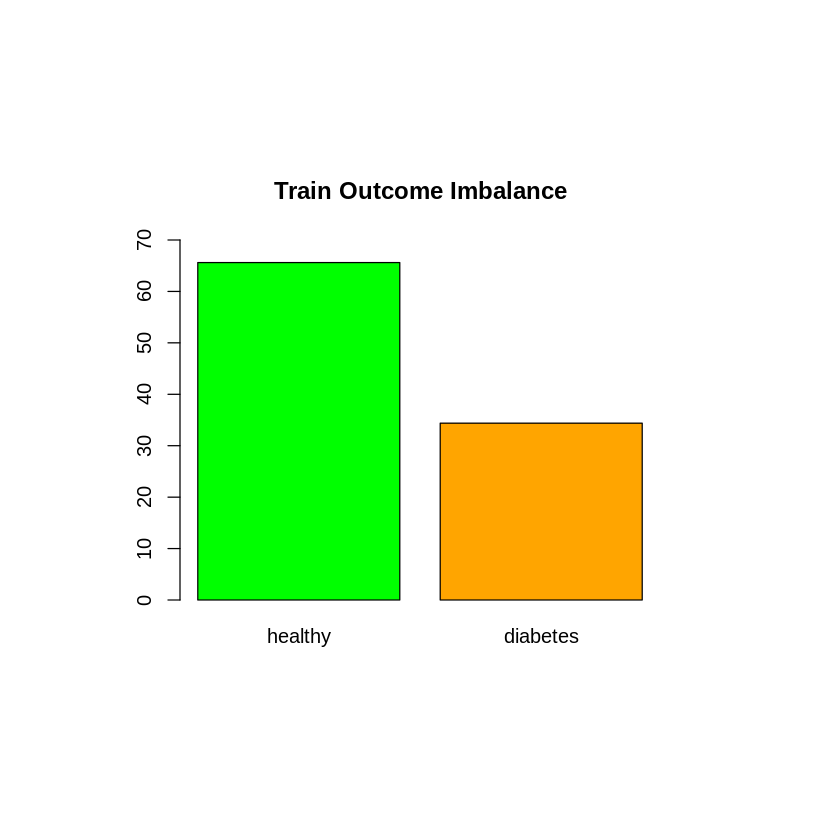

In [47]:
#::GMG::Plot the imbalance, see wether percentage is kept
#::NOTE::I don't know how to make the fig smaller and the margins tight (!?)
par(pin = c(4,3))
barplot(100*prop.table(table(pima_train$Outcome)), 
        col = c('green', 'orange'),
        ylim = c(0,70),
        main = 'Train Outcome Imbalance')

In [48]:
str(pima_test)

'data.frame':	218 obs. of  9 variables:
 $ Pregnancies             : int  1 1 5 3 10 1 10 5 3 10 ...
 $ Glucose                 : int  85 89 116 78 168 189 125 117 158 122 ...
 $ BloodPressure           : int  66 66 74 50 74 60 70 92 76 78 ...
 $ SkinThickness           : int  29 23 0 32 0 23 26 0 36 31 ...
 $ Insulin                 : int  0 94 0 88 0 846 115 0 245 0 ...
 $ BMI                     : num  26.6 28.1 25.6 31 38 30.1 31.1 34.1 31.6 27.6 ...
 $ DiabetesPedigreeFunction: num  0.351 0.167 0.201 0.248 0.537 0.398 0.205 0.337 0.851 0.512 ...
 $ Age                     : int  31 21 30 26 34 59 41 38 28 45 ...
 $ Outcome                 : Factor w/ 2 levels "healthy","diabetes": 1 1 1 2 2 2 2 1 2 1 ...


In [49]:
prop.table(table(pima_test$Outcome))


  healthy  diabetes 
0.6559633 0.3440367 

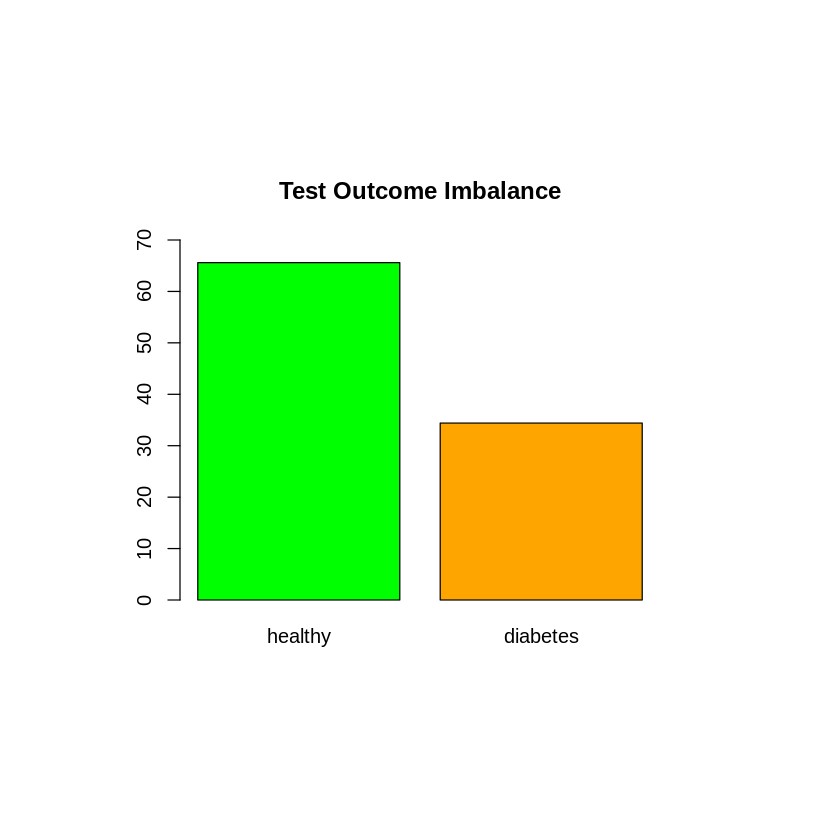

In [50]:
#::GMG::Plot the imbalance, see wether percentage is kept
#::NOTE::I don't know how to make the fig smaller and the margins tight (!?)
par(pin = c(4,3))
barplot(100*prop.table(table(pima_test$Outcome)), 
        col = c('green', 'orange'),
        ylim = c(0,70),
        main = 'Test Outcome Imbalance')

## Models

### knn

### decision tree

### logit

### random forest

### gradient boosting